In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import shutil
import tensorflow as tf
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

In [ ]:
def split_dataset(source_folder, output_root_folder):
    # creating output folders if they don't exist
    target_defect_folder = os.path.join(output_root_folder, "Defect_images")
    target_no_defect_folder = os.path.join(output_root_folder, "NODefect_images")
    os.makedirs(target_defect_folder, exist_ok=True)
    os.makedirs(target_no_defect_folder, exist_ok=True)

    # split defect images
    defect_images_folder = os.path.join(source_folder, "Defect_images")

    # copy defect images
    for file_name in os.listdir(defect_images_folder):
        source_path = os.path.join(defect_images_folder, file_name)
        target_path = os.path.join(target_defect_folder, file_name)
        shutil.copy2(source_path, target_path)

    # copy non-defect images
    no_defect_images_folder = os.path.join(source_folder, "NODefect_images")
    for subfolder_name in os.listdir(no_defect_images_folder):
        subfolder_path = os.path.join(no_defect_images_folder, subfolder_name)
        if os.path.isdir(subfolder_path):
            for file_name in os.listdir(subfolder_path):
                source_path = os.path.join(subfolder_path, file_name)
                target_path = os.path.join(target_no_defect_folder, file_name)
                shutil.copy2(source_path, target_path)

# source folder and the output root directory
dataset_folder = "/content/drive/MyDrive/textile"
output_root_folder = "/content/drive/MyDrive/project output"


split_dataset(dataset_folder, output_root_folder)

In [ ]:
def preprocess_data(defect_folder, nodefect_folder):
    defect_images = load_images_from_folder(defect_folder)
    nodefect_images = load_images_from_folder(nodefect_folder)

    # augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.8, 1.2]
    )

    augmented_images = []
    for img in defect_images:
        augmented_images.append(img)
        img = np.expand_dims(img, axis=0)
        it = datagen.flow(img, batch_size=1)
        for _ in range(4):  # 4 augmented images per original image
            batch = it.next()
            augmented_img = batch[0].astype('uint8')
            augmented_images.append(augmented_img)

    # combine defect and non-defect images
    X = np.concatenate((augmented_images, nodefect_images))
    y = np.concatenate((np.ones(len(augmented_images)), np.zeros(len(nodefect_images))))

    # shuffle
    X, y = shuffle(X, y, random_state=57)

    return X, y

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))
            images.append(img)
    return images

In [ ]:
def plot_class_distribution(y):
    unique, counts = np.unique(y, return_counts=True)
    labels = ['Defect', 'No Defect']
    plt.pie(counts, labels=labels, autopct='%1.1f%%')
    plt.title('Class Distribution')
    plt.show()

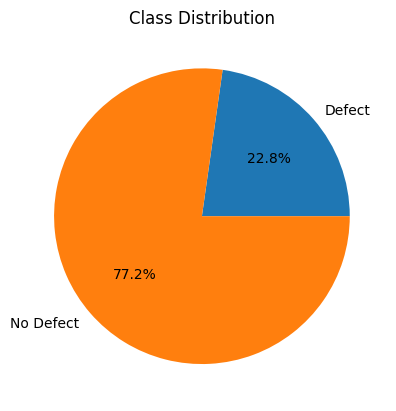

In [ ]:
defect_folder = os.path.join(output_root_folder, "Defect_images")
nodefect_folder = os.path.join(output_root_folder, "NODefect_images")

X, y = preprocess_data(defect_folder, nodefect_folder)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=57)


plot_class_distribution(y_train)

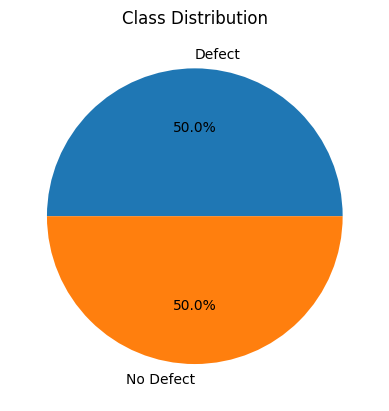

In [ ]:
smote = SMOTE(random_state=57)
X_train, y_train = smote.fit_resample(X_train.reshape(-1, 224 * 224 * 3), y_train)

X_train = X_train.reshape(-1, 224, 224, 3)

plot_class_distribution(y_train)

In [ ]:
# create a baseline model to get the baseline metric
baseline_model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer"),
        tf.keras.layers.Conv2D(3, 1, padding="valid", activation="relu"),
        tf.keras.layers.Conv2D(16, 2, activation="relu"),
        tf.keras.layers.Conv2D(32, 2, activation="relu"),
        tf.keras.layers.Conv2D(64, 3, activation="relu", kernel_regularizer="l2"),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 4, activation="relu", kernel_regularizer="l2"),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(512, 4, activation="relu", kernel_regularizer="l2"),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1, activation="sigmoid", name="output_layer")
    ]
)

# get model summary
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 3)       12        
                                                                 
 conv2d_1 (Conv2D)           (None, 223, 223, 16)      208       
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      2080      
                                                                 
 conv2d_3 (Conv2D)           (None, 220, 220, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 64)      0         
 D)                                                              
                                                                 
 conv2d_4 (Conv2D)           (None, 107, 107, 128)     131200    
                                                        

In [ ]:
import tensorflow as tf
import numpy as np

# select a single matrix from X_train
input_matrix = X_train[0]

# propagate the input matrix through each layer and show the transformation
for i, layer in enumerate(baseline_model.layers):
    intermediate_model = tf.keras.models.Model(inputs=baseline_model.input, outputs=layer.output)
    intermediate_output = intermediate_model.predict(np.expand_dims(input_matrix, axis=0))

    print("Layer", i+1, "Name:", layer.name)
    print("Input Shape:", intermediate_output.shape)
    print("Input Data Summary:")
    print(intermediate_output[0])
    print("--------------------------------------")

1/1 [==============================] - 0s 208ms/step
Layer 1 Name: conv2d
Input Shape: (1, 224, 224, 3)
Input Data Summary:
[[[  0.        0.      313.52805]
  [  0.        0.      313.52805]
  [  0.        0.      313.52805]
  ...
  [  0.        0.      145.08357]
  [  0.        0.      130.3293 ]
  [  0.        0.      154.91974]]

 [[  0.        0.      313.52805]
  [  0.        0.      313.52805]
  [  0.        0.      313.52805]
  ...
  [  0.        0.      141.395  ]
  [  0.        0.      141.395  ]
  [  0.        0.      136.47691]]

 [[  0.        0.      313.52805]
  [  0.        0.      313.52805]
  [  0.        0.      313.52805]
  ...
  [  0.        0.      135.24739]
  [  0.        0.      156.14926]
  [  0.        0.      127.87027]]

 ...

 [[  0.        0.      313.52805]
  [  0.        0.      313.52805]
  [  0.        0.      313.52805]
  ...
  [  0.        0.      129.09978]
  [  0.        0.      163.52638]
  [  0.        0.      138.93596]]

 [[  0.        0.     

1/1 [==============================] - 0s 209ms/step
Layer 5 Name: max_pooling2d
Input Shape: (1, 110, 110, 64)
Input Data Summary:
[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.02204657 0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 

1/1 [==============================] - 0s 337ms/step
Layer 6 Name: conv2d_4
Input Shape: (1, 107, 107, 128)
Input Data Summary:
[[[ 0.          3.672762    9.585197   ...  0.          0.
    6.2056074 ]
  [ 0.          3.874218    9.664388   ...  0.          0.
    5.9910927 ]
  [ 0.          0.4737252  10.055404   ...  0.          0.
    6.219587  ]
  ...
  [ 0.          1.6555537   5.1114445  ...  0.          0.
    4.125231  ]
  [ 0.          0.4175442   4.28404    ...  0.          0.
    3.706074  ]
  [ 0.          1.5183187   4.304735   ...  0.          0.
    3.6771195 ]]

 [[ 0.          3.672762    9.585197   ...  0.          0.
    6.2056074 ]
  [ 0.          3.8716052   9.716311   ...  0.          0.
    6.002484  ]
  [ 0.          0.34249115 10.254133   ...  0.          0.
    5.829416  ]
  ...
  [ 0.          2.4679413   5.1285467  ...  0.          0.
    4.0895243 ]
  [ 0.          0.5481779   4.7795763  ...  0.          0.
    3.2382298 ]
  [ 0.          0.44513842  4.888

In [ ]:
import tensorflow as tf
import numpy as np

# small subset of X_train
subset_size = 100
X_train_subset = X_train[:subset_size]

# summarized statistics of the transformation of input data over each layer
for layer in baseline_model.layers:
    intermediate_model = tf.keras.models.Model(inputs=baseline_model.input, outputs=layer.output)
    intermediate_output = intermediate_model.predict(X_train_subset)

    print("Layer Name:", layer.name)
    print("Input Shape:", intermediate_output.shape)
    print("Input Data Summary:")
    print("Mean:", np.mean(intermediate_output))
    print("Std Dev:", np.std(intermediate_output))
    print("Min:", np.min(intermediate_output))
    print("Max:", np.max(intermediate_output))
    print("--------------------------------------")

4/4 [==============================] - 0s 42ms/step
Layer Name: conv2d
Input Shape: (100, 224, 224, 3)
Input Data Summary:
Mean: 51.59938
Std Dev: 81.08235
Min: 0.0
Max: 313.52805
--------------------------------------
4/4 [==============================] - 1s 272ms/step
Layer Name: conv2d_1
Input Shape: (100, 223, 223, 16)
Input Data Summary:
Mean: 21.68847
Std Dev: 28.558552
Min: 0.0
Max: 149.26416
--------------------------------------
4/4 [==============================] - 2s 335ms/step
Layer Name: conv2d_2
Input Shape: (100, 222, 222, 32)
Input Data Summary:
Mean: 11.814806
Std Dev: 15.442521
Min: 0.0
Max: 119.36972
--------------------------------------
4/4 [==============================] - 5s 1s/step
Layer Name: conv2d_3
Input Shape: (100, 220, 220, 64)
Input Data Summary:
Mean: 4.406945
Std Dev: 7.6662235
Min: 0.0
Max: 55.526337
--------------------------------------
4/4 [==============================] - 7s 1s/step
Layer Name: max_pooling2d
Input Shape: (100, 110, 110, 64)
In

In [ ]:
from keras.callbacks import EarlyStopping
# define callbacks
# ReduceLROnPlateau callback to reduce learning rate if model's val_loss doesn't improve for 1 epochs
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=1,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

# EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3, # if val_accuracy decreases for 3 epochs in a row, stop training
                                                  restore_best_weights=True,
                                                  verbose=1)

In [ ]:
# compile the `baseline_model`
baseline_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["accuracy"])

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

In [ ]:
class_weight = {0: 1, 1: 1}  # was used to adjust class if not using class balancing techniques
history = baseline_model.fit(X_train, y_train, epochs=10, batch_size=50, validation_data=(X_test, y_test),
                    class_weight=class_weight, callbacks=[early_stopping] )

Epoch 1/10
17/17 [==============================] - 756s 45s/step - loss: 7.9981 - accuracy: 0.5894 - val_loss: 3.6223 - val_accuracy: 0.1407
Epoch 2/10
17/17 [==============================] - 742s 44s/step - loss: 2.5736 - accuracy: 0.7307 - val_loss: 2.6482 - val_accuracy: 0.5333
Epoch 3/10
17/17 [==============================] - 717s 42s/step - loss: 2.2750 - accuracy: 0.7621 - val_loss: 2.1166 - val_accuracy: 0.8593
Epoch 4/10
17/17 [==============================] - 713s 42s/step - loss: 2.1347 - accuracy: 0.7452 - val_loss: 2.0170 - val_accuracy: 0.8444
Epoch 5/10
17/17 [==============================] - 725s 43s/step - loss: 1.9325 - accuracy: 0.8007 - val_loss: 1.8497 - val_accuracy: 0.8519
Epoch 6/10
17/17 [==============================] - 705s 42s/step - loss: 1.8231 - accuracy: 0.7923 - val_loss: 1.9314 - val_accuracy: 0.7926
Epoch 7/10
17/17 [==============================] - 702s 41s/step - loss: 1.7030 - accuracy: 0.8225 - val_loss: 1.7335 - val_accuracy: 0.8000
Epoch 